# Imports

In [88]:
import pandas as pd
import numpy as np


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Funções

In [89]:



def plot_confusion_matrix(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if labels is None:
        labels = np.unique(y_true)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


# Data Load

In [49]:
df = pd.read_csv('credit_risk_dataset.csv')

In [50]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


# 1.0 Data Description

In [51]:
df1 = df.copy()

## 1.1 Dimensão dos Dados

In [52]:
df1.shape

(32581, 12)

## 1.2 Tipo dos Dados

In [53]:
df1.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

## 1.3 Check Na

In [54]:
df1.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

## 1.4 Fill Na

In [55]:
df1 = df1.dropna()

In [56]:
df1.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## 1.5 Estatística Descritiva

In [57]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(include=['object'])

### 1.5.1 Variáveis Numéricas

In [58]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,person_age,20.00,144.00,124.00,27.727216,26.00,6.310331,2.564863,18.718747
1,person_income,4000.00,6000000.00,5996000.00,66649.371884,55956.00,62355.358694,35.190623,2956.064707
2,person_emp_length,0.00,123.00,123.00,4.788672,4.00,4.154554,2.752939,47.639702
3,loan_amnt,500.00,35000.00,34500.00,9656.493121,8000.00,6329.572848,1.174480,1.350012
4,loan_int_rate,5.42,23.22,17.80,11.039867,10.99,3.229315,0.203978,-0.661337
5,loan_status,0.00,1.00,1.00,0.216600,0.00,0.411928,1.376039,-0.106523
6,loan_percent_income,0.00,0.83,0.83,0.169488,0.15,0.106391,1.077710,1.291548
7,cb_person_cred_hist_length,2.00,30.00,28.00,5.793736,4.00,4.038412,1.663378,3.730311


### 1.5.2 Variáveis Categóricas

In [59]:
cat_attributes.describe().T

,count,unique,top,freq
person_home_ownership,28638,4,RENT,14551
loan_intent,28638,6,EDUCATION,5704
loan_grade,28638,7,A,9402
cb_person_default_on_file,28638,2,N,23535


# 2.0 Feature Engineering

In [60]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

## 2.2 Criação das Hipóteses

## 2.3 Feature Engineering

# 3.0 Filtragem de Variáveis

In [61]:
df3 = df2.copy()

## 3.1 Filtragem de Linhas

## 3.2 Filtragem de Colunas

# 4.0 Análise Exploratória de Dados

In [62]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Variável Resposta

### 4.1.2 Variáveis Numéricas

### 4.1.3 Variáveis Categóricas

## 4.2 Análise Bivariada

## 4.3 Análise Multivariada

### 4.3.1 Atributos Numéricos

### 4.3.2 Atributos Categóricos

# 5.0 Data Preparation

In [63]:
df5 = df4.copy()

## 5.1 Variáveis Numéricas

## 5.2 Variáveis Categóricas

In [64]:
cat_att = df5.select_dtypes(include='object')

In [65]:
le = LabelEncoder()
for i in cat_att.columns:
    df5[i] = le.fit_transform(df5[i].values)

# 6.0 Seleção de atributos

In [66]:
df6 = df5.copy()

## 6.1 Feature Importance - Árvore

## 6.2 Regularização das Regressões

### 6.2.1 Lasso

### 6.2.2 Ridge

## 6.3 BORUTA

# 7.0 Machine Learning Model

In [67]:
df7 = df6.copy()

In [68]:
X = df7.drop('loan_status', axis=1)
y = df7['loan_status']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

## 7.1 Random Forest

In [70]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)
yhat = rf.predict(X_test)

### 7.1.1 Random Forest Performance

In [71]:
print( precision_score(y_test, yhat) )
print( recall_score(y_test, yhat) )

0.956973293768546
0.6928034371643395


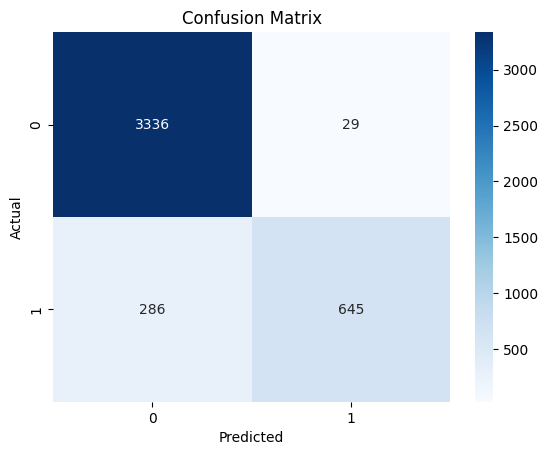

In [90]:
plot_confusion_matrix(y_test, yhat, labels=y_test.unique())

### 7.1.2 Random Forest Performance - Cross Validation

## 7.2 Decision Tree

In [75]:
dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)

yhat_dt = dt.predict(X_test)


### 7.2.1 Decision Tree Performance

In [76]:
print( precision_score(y_test, yhat_dt) )
print( recall_score(y_test, yhat_dt) )

0.7308488612836439
0.7583243823845328


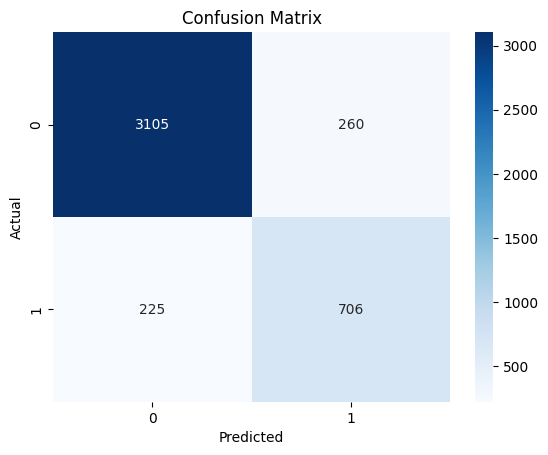

In [91]:
plot_confusion_matrix(y_test, yhat_dt, labels=y_test.unique())

### 7.2.2 Decision Tree Performance - Cross Validation

## 7.3 LightGBM Classifier

In [81]:
lg = lgb.LGBMClassifier()

lg.fit(X_train, y_train)
yhat_lg = lg.predict(X_test)


[LightGBM] [Info] Number of positive: 5272, number of negative: 19070
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 24342, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216580 -> initscore=-1.285707
[LightGBM] [Info] Start training from score -1.285707


### 7.3.1 LightGBM Performance

In [82]:
print( precision_score(y_test, yhat_lg) )
print( recall_score(y_test, yhat_lg) )

0.9748520710059172
0.7078410311493019


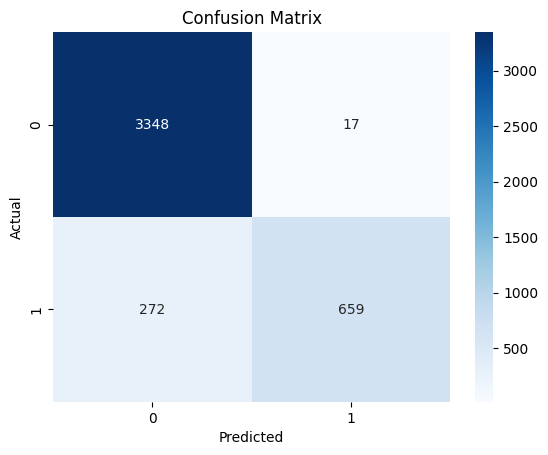

In [92]:
plot_confusion_matrix(y_test, yhat_lg, labels=y_test.unique())

### 7.3.2 LightGBM Performance - Cross Validation

## 7.4 XGBoost

In [85]:
# Criar o classificador XGBoost
xgb_classifier = xgb.XGBClassifier()

# Treinar o classificador
xgb_classifier.fit(X_train, y_train)

# Fazer previsões
yhat_xgb = xgb_classifier.predict(X_test)

### 7.4.1 XGBoost Performance

In [86]:
print( precision_score(y_test, yhat_xgb) )
print( recall_score(y_test, yhat_xgb) )

0.9424157303370787
0.7207303974221267


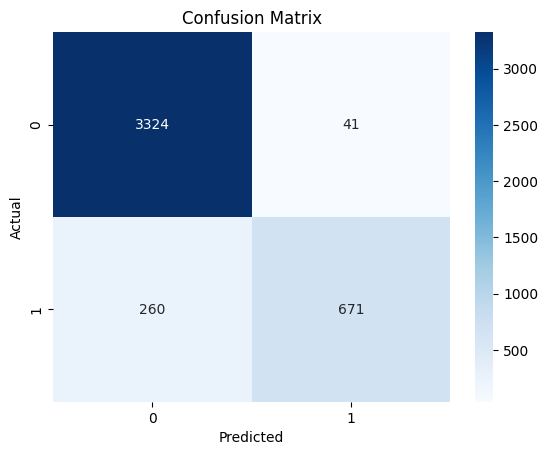

In [93]:
plot_confusion_matrix(y_test, yhat_xgb, labels=y_test.unique())

### 7.4.2 XGBoost Performance - Cross Validation